# Illustrating the use of ODM2 REST web services with the ODM2 Marchantaria use case
This IPython (Jupyter) notebook demonstrates the use of the [ODM2 REST API's (web services)](http://sis-devel.cloudapp.net/docs/) from Python. It uses my [Marchantaria Time Series data use case](https://github.com/ODM2/ODM2/tree/master/usecases/marchantariats) (1), which has been loaded at UCSD into an ODM2 database. I rely on the JSON output formats, issuing ["Observation" service requests](http://sis-devel.cloudapp.net/docs/#!/Observations) (2). Note that in this context, an `Observation` includes all `core` ODM2 properties plus basic `SamplingFeatures` extension properties (from Sites, Specimens, and RelatedFeatures). `ResultValues` are not included. A simple query (3) and processing pattern is followed:
1. Get "Observations" based on a query criteria; here, I use VariableCode.
2. Step through list of ResultUUID's returned by the above request to get result values (`<ResultTypeCV>Results` and `<ResultTypeCV>ResultValues`)
3. Extract information form Result and ResultValues responses and create a Pandas DataFrame with the resulting time series data.
4. Do fun things with the responses, including plotting the SamplingFeature Site on an inline, interactive map; and plotting time series figures annotated with rich information extracted from the Observations.

While all queries and processing steps are fairly generic and could be applied to other use cases, they do rely on a couple of assumptions about the dataset:
1. All `Results` are associated with a single `Site SamplingFeature` via a `RelatedFeature`.
2. The [`ResultTypeCV`](http://vocabulary.odm2.org/resulttype/) of all `Results` is [`measurement`](http://vocabulary.odm2.org/resulttype/measurement/). This means that there are specific attribute names found in the response from the "value" service request.
3. The collection of measurement results for each variable can be treated as a time series.

*Footnotes:*
1. Except for the `value` request, all `Observations` requests are effectively what in ODM2 we have referred to as "Catalog" requests.
2. It's important to note that while the [Marchantaria dataset](https://github.com/ODM2/ODM2/tree/master/usecases/marchantariats) (biogeochemical and hydrological data from a site on the central Amazon River mainstem) was collected and can be viewed as a "time series" (and that's how it's treated here), it's not a "TimeSeries" ([`timeseriesCoverage`](http://vocabulary.odm2.org/resulttype/timeSeriesCoverage/)) in the ODM2 [`ResultTypeCV`](http://vocabulary.odm2.org/resulttype/) sense. All its results have a [`measurement`](http://vocabulary.odm2.org/resulttype/measurement/) `ResultTypeCV`.
For each variable, there's a time series of individual measurements, with corresponding individual `Results` and `MeasurementResultValues` (one MeasurementResultValue per Result).
3. A similar sequence of two queries can be issued manually on a browser (remove the `?format=json` string to get a YAML response):
    a. http://sis-devel.cloudapp.net:80/Observations/samplingfeatureCode/sta1036exp1300smp336_fp/?format=json
    b. http://sis-devel.cloudapp.net:80/Observations/value/20224a83-c364-51b2-34ed-6eb29f23265c/?format=json

[Emilio Mayorga](http://github.com/emiliom/), 8/9/2015

In [1]:
%matplotlib inline
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
#import mpld3
from IPython.display import HTML
import folium

In [2]:
# IPython "version_information" extension needs to be installed
# %install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information numpy, scipy, pandas, matplotlib, mpld3, folium

Software versions
Python 2.7.10 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 3.2.0
OS Linux 3.13.0 61 generic x86_64 with debian jessie sid
numpy 1.9.2
scipy 0.15.1
pandas 0.16.2
matplotlib 1.4.3
mpld3 0.2
folium 0.1.4
Sun Aug 09 15:52:48 2015 PDT

### Helper functions and configurations

In [3]:
# For Folium map
def inline_map(map, height=500):
    """
    Folium inline, interactive map using Leaflet.
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    iframe = '<iframe srcdoc="{srcdoc}" style="width: 100%%; height: %dpx; border: none"></iframe>' % height
    return HTML(iframe.format(srcdoc=map.HTML.replace('"', '&quot;')))

In [4]:
# For matplotlib plots, including time series plots
matplotlib.style.use('ggplot')
#mpld3.enable_notebook()

create_ylabel = lambda indf: indf.ix[0].UnitsTypeCV + ' (' + indf.ix[0].UnitsAbbrev + ')'

def get_title(VariableCode, observations, SiteRelatedSF, lat, lon):
    title = "%s (%s) specimen measurement results\n at %s (lat %.3f, lon %.3f), a %s / %s Site " % (
        VariableCode, observations[0]['Variable']['VariableNameCV'],
        SiteRelatedSF['SamplingFeatureName'], lat, lon,
        SiteRelatedSF['SamplingFeatureTypeCV'], SiteRelatedSF['Site']['SiteTypeCV']
    )
    return title

In [5]:
# For ODM2 REST requests
params = {'format': 'json'}

def odm2rest_request(service, request, value, params):
    baseurl = "http://sis-devel.cloudapp.net:80"
    request_url = "%s/%s/%s/%s" % (baseurl, service, request, value)
    r = requests.get(request_url, params=params)
    return r.json()

def get_odm2rest_measresultvalues_df(obs, params):
    """
    Issue ODM2 REST Observatoins/value request, return a selective "record" (dict)
    """
    resultvalues_obs = odm2rest_request("Observations", "value", obs['ResultUUID'], params)
    # For measurement result type, there's only one result value per result
    measresult = resultvalues_obs[0]
    measresultvalues = measresult['MeasurementResult']['MeasurementResultValues']
    # Note that the last 3 dict items below are actually by Result, not by ResultValue
    resultvalue_record = {'ValueDateTime': measresultvalues['ValueDateTime'],
                          'DataValue': measresultvalues['DataValue'],
                          'CensorCodeCV': measresult['MeasurementResult']['CensorCodeCV'],
                          'UnitsTypeCV': obs['Unit']['UnitsTypeCV'],
                          'UnitsAbbrev': obs['Unit']['UnitsAbbreviation']
                         }
    return resultvalue_record

### Request observations for VariableCode 'FPOC' (Fine Particulate Organic Carbon)

In [6]:
VariableCode = 'FPOC'

In [7]:
observations = odm2rest_request("Observations", "variableCode", VariableCode, params)
len(observations)

122

In [8]:
# ResultDateTime range (min & max)
ls = pd.to_datetime([obs['ResultDateTime'] for obs in observations])
ls.min(), ls.max()

(Timestamp('1983-01-17 00:00:00'), Timestamp('1989-12-12 00:00:00'))

In [9]:
# Related Site SamplingFeature (just one)
# ** Applicable also to all other specimens in the Marchantaria use case; for now **
SiteRelatedSF = observations[0]['RelatedFeatures'][0]
lat, lon = SiteRelatedSF['Site']['Latitude'], SiteRelatedSF['Site']['Longitude']

### Show the Site SamplingFeature on an inline, interactive map, as a clickable marker

In [10]:
# Text/HTML content for marker popup
popup_str = '<b>%s</b><br>' % SiteRelatedSF['SamplingFeatureName']
popup_str += 'A %s / %s Site<br>' % (SiteRelatedSF['SamplingFeatureTypeCV'],
                                    SiteRelatedSF['Site']['SiteTypeCV'])
popup_str += 'SamplingFeatureUUID:<br>%s' % SiteRelatedSF['SamplingFeatureUUID']

In [11]:
mapheight = 300
map = folium.Map(width=500, height=mapheight, location=[lat, lon], zoom_start=6)
map.simple_marker([lat, lon], popup=popup_str)
inline_map(map, mapheight+10)

### Request result values for each observation (by result uuid), then import into Pandas DataFrame

In [12]:
resultvalue_records = [get_odm2rest_measresultvalues_df(obs, params) for obs in observations]
len(resultvalue_records)

122

In [13]:
resultvalue_df = pd.DataFrame.from_records(resultvalue_records)
resultvalue_df['dtutc'] = pd.to_datetime(resultvalue_df['ValueDateTime'], 
                                         utc=True, infer_datetime_format=True)

In [14]:
resultvalue_df.head(10)

,CensorCodeCV,DataValue,UnitsAbbrev,UnitsTypeCV,ValueDateTime,dtutc
0,Not censored,2.90,mg/L,Mass concentration,1983-01-17 00:00:00,1983-01-17
1,Not censored,1.10,mass %,Mass fraction,1983-01-17 00:00:00,1983-01-17
2,Not censored,2.94,mg/L,Mass concentration,1983-01-27 00:00:00,1983-01-27
3,Not censored,1.10,mass %,Mass fraction,1983-01-27 00:00:00,1983-01-27
4,Not censored,3.17,mg/L,Mass concentration,1983-02-08 00:00:00,1983-02-08
5,Not censored,1.20,mass %,Mass fraction,1983-02-08 00:00:00,1983-02-08
6,Not censored,3.32,mg/L,Mass concentration,1983-02-21 00:00:00,1983-02-21
7,Not censored,1.40,mass %,Mass fraction,1983-02-21 00:00:00,1983-02-21
8,Not censored,2.74,mg/L,Mass concentration,1983-03-03 00:00:00,1983-03-03
9,Not censored,1.20,mass %,Mass fraction,1983-03-03 00:00:00,1983-03-03


### Plot time series of the two FPOC types
Same VariableCode, but distinguished by UnitsTypeCV

In [15]:
resultvalue_df.groupby(['UnitsTypeCV', 'UnitsAbbrev']).dtutc.nunique()

UnitsTypeCV         UnitsAbbrev
Mass concentration  mg/L           60
Mass fraction       mass %         62
Name: dtutc, dtype: int64

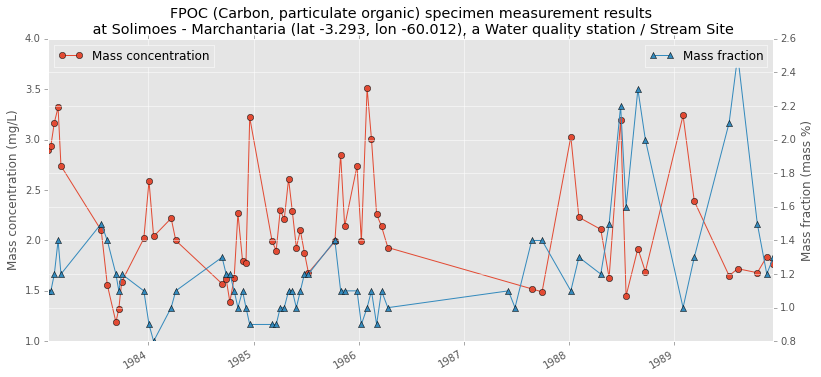

In [16]:
plt.figure(figsize=(13,6))

df = resultvalue_df[resultvalue_df.UnitsTypeCV == 'Mass concentration']
df.set_index('dtutc', inplace=True)
ax = df['DataValue'].plot(style='o-', label=df.ix[0].UnitsTypeCV)
ax.set_ylabel(create_ylabel(df))

df = resultvalue_df[resultvalue_df.UnitsTypeCV == 'Mass fraction']
df.set_index('dtutc', inplace=True)
df['DataValue'].plot(style='^-', label=df.ix[0].UnitsTypeCV,
                     ax=ax, secondary_y=True)
ax.right_ax.set_ylabel(create_ylabel(df))

ax.legend(loc=2)
ax.right_ax.legend(loc=1)
ax.xaxis.grid(True, which="major")
ax.set_xlabel('')
ax.set_title(get_title(VariableCode, observations, SiteRelatedSF, lat, lon));

### Now request and plot NO3 (nitrate)

In [17]:
VariableCode = 'NO3'
observations = odm2rest_request("Observations", "variableCode", VariableCode, params)
len(observations)

96

In [18]:
# ResultDateTime range (min & max)
ls = pd.to_datetime([obs['ResultDateTime'] for obs in observations])
ls.min(), ls.max()

(Timestamp('1983-01-17 00:00:00'), Timestamp('1993-08-24 00:00:00'))

In [19]:
resultvalue_records = [get_odm2rest_measresultvalues_df(obs, params) for obs in observations]
len(resultvalue_records)

96

In [20]:
resultvalue_df = pd.DataFrame.from_records(resultvalue_records)
resultvalue_df['dtutc'] = pd.to_datetime(resultvalue_df['ValueDateTime'], 
                                         utc=True, infer_datetime_format=True)

In [21]:
resultvalue_df.groupby(['UnitsTypeCV', 'UnitsAbbrev']).dtutc.nunique()

UnitsTypeCV          UnitsAbbrev
Molar concentration  uM             96
Name: dtutc, dtype: int64

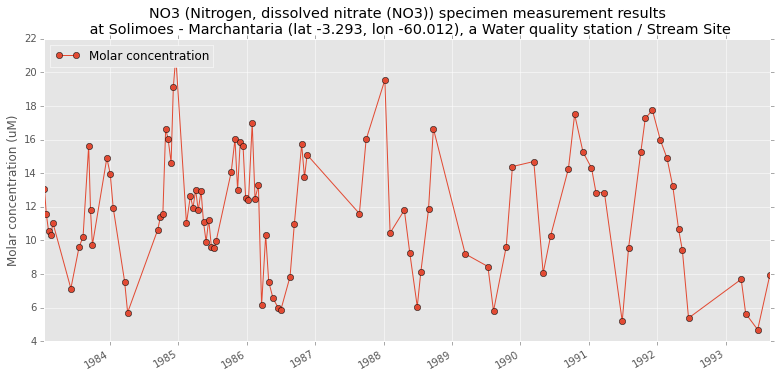

In [22]:
plt.figure(figsize=(13,6))

df = resultvalue_df
df.set_index('dtutc', inplace=True)
ax = df['DataValue'].plot(style='o-', label=df.ix[0].UnitsTypeCV)
ax.set_ylabel(create_ylabel(df))

ax.legend(loc=2)
ax.xaxis.grid(True, which="major")
ax.set_xlabel('')
ax.set_title(get_title(VariableCode, observations, SiteRelatedSF, lat, lon));

#### An extra, fun plot
A complementary view of the same NO3 data, but by day of the year, focusing on seasonal variability by lumping data from all years.

In [23]:
df['dayofyear'] = df.index.dayofyear

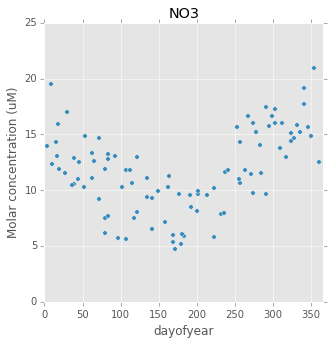

In [24]:
ax = df.plot(kind='scatter', x='dayofyear', y='DataValue', 
             xlim=[0,366], figsize=(5,5))
ax.set_ylabel(create_ylabel(df))
ax.set_title(VariableCode);

This variation on the seasonal plot symbolizes the year using a colormap. *BUT I seem to have a bug, such that the x-axis label and tick labels disappear, and I can't figure out how to bring them back. Darn.*

In [25]:
df['year'] = df.index.year

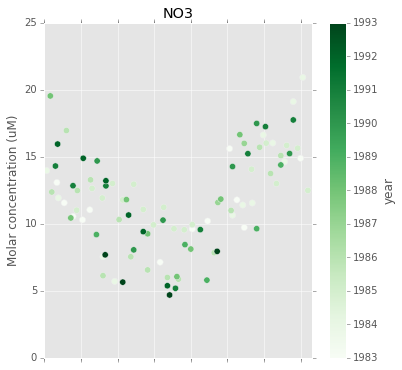

In [26]:
ax = df.plot(kind='scatter', x='dayofyear', y='DataValue', c='year', 
             s=40, colormap='Greens', xlim=[0,366], figsize=(6,6))
ax.set_ylabel(create_ylabel(df))
ax.set_title(VariableCode);